## COMP 4431 Assignment 5
Eduardo Vasquez-Villalpando (collaborative coding with Dillon Dugan and Patrick Segui)

In [1]:
#imports
from sklearn.datasets import load_iris
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA, KernelPCA, FastICA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import Image
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import PolynomialFeatures
from sklearn.mixture import GaussianMixture
from tabulate import tabulate
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings('ignore')

In [2]:
class LabelTransformer(BaseEstimator, ClusterMixin):
    """
    Label transformer adjusts outputs of cluster data into labels that match up with the true label
    this allows you to use a number of categorization metrics like f1 score or accuracy.
    """
    def __init__(self):
        self.input_labels = None
        self.truth_labels = None
        self.unique_labels = None
        self.truth_unique_labels = None
        self.labels_ = None
        self.match_nums = []
        
    def fit(self, X, y=None):
        self.input_labels = X
        self.truth_labels = y
        self.unique_labels = np.unique(self.input_labels)
        self.truth_unique_labels = np.unique(y)
        self.labels_ = np.empty_like(X)
        
        return self
    
    def fit_transform(self, X, y=None):
        self.fit(X,y)
        return self.transform(X)
        
    def transform(self, X, y=None):
        for k in self.unique_labels:
            self.match_nums = ([np.sum((self.input_labels==k)*(self.truth_labels==t)) for t in self.truth_unique_labels])
            self.labels_[self.input_labels==k] = self.truth_unique_labels[np.argmax(self.match_nums)]
        return self.labels_
    
    def predict(self, X):
        for k in self.unique_labels:
            self.match_nums = ([np.sum((self.input_labels==k)*(self.truth_labels==t)) for t in self.truth_unique_labels])
            self.labels_[self.input_labels==k] = self.truth_unique_labels[np.argmax(self.match_nums)]
        return self.labels_

In [3]:
iris = load_iris()
iris_df = pd.DataFrame(iris.data, columns = ['sepal_length','sepal_width', 'petal_length', 'petal_width'])
iris_df['target'] = iris.target

# Preprocessing the data with Principal Component Analysis (PCA)
Here, we'll largely be retreading PCA explored in the previous assignment, however, with an added dimension to account for slightly more variance. To reiterate, Principal Component Analysis is a technique for dimensionality reduction. While the Iris dataset is of relatively few dimensions, it's still a useful technique to practice, as clustering with many dimensions can be computationally expensive.

In [5]:
feature_columns = ['sepal_length','sepal_width', 'petal_length', 'petal_width']
scaler = StandardScaler().fit(iris_df[['sepal_length','sepal_width', 'petal_length', 'petal_width']])
scaled_iris_df = pd.DataFrame(scaler.transform(iris_df[feature_columns]), columns = feature_columns)
scaled_iris_df['target'] = iris_df.target

pca = PCA(n_components=4).fit(scaled_iris_df[feature_columns])
pca_variance = pd.DataFrame({'pc':["PC"+str(i) for i in range(1, len(feature_columns)+1)], 'var': pca.explained_variance_})

Component      Explained Variance
-----------  --------------------
PCA1                   0.729624
PCA2                   0.228508
PCA3                   0.0366892
PCA4                   0.00517871


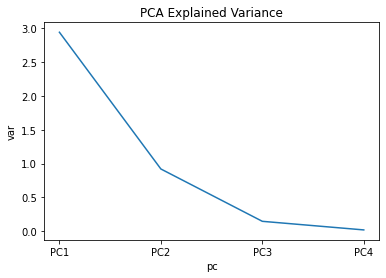

In [6]:
print(tabulate([['PCA1', pca.explained_variance_ratio_[0]],
               ['PCA2', pca.explained_variance_ratio_[1]],
               ['PCA3', pca.explained_variance_ratio_[2]],
               ['PCA4', pca.explained_variance_ratio_[3]]],
               headers = ['Component', 'Explained Variance']))
pca_elbow = sns.lineplot(data=pca_variance, x = 'pc', y ='var').set_title('PCA Explained Variance');

Based on the figure and table, the elbow kind of "bottoms out" after the 3rd component, so adding a 4th dimension from PCA won't add much variance explanation, so we'll stick with 3 in this case. Now, to transform the PCA dataframe to account for this and show some exploratory pairplots to visualize the change.

In [7]:
pca = PCA(n_components=3).fit(scaled_iris_df[feature_columns])
pca_iris_df = pd.DataFrame(pca.transform(scaled_iris_df[feature_columns]), columns = ['PC1', 'PC2', 'PC3'])
pca_iris_df['target'] = iris_df.target

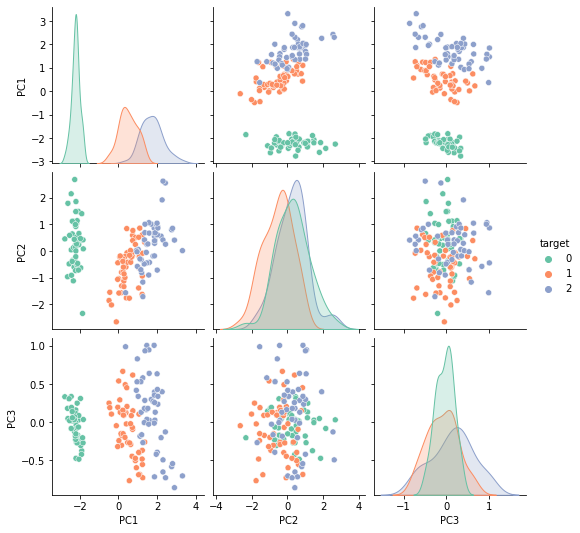

In [7]:
sns.pairplot(pca_iris_df, hue='target', palette='Set2')

As seen in the pairplots, it might still be difficult to tease apart the few intersecting points for target 1 and 2. Next, we'll input the PCA matrix into numeruous clustering algorithms and score them using a number of criteria.

# Clustering
We'll begin by inputting the PCA matrix into a k-means clustering algorithm, as its usecases are perhaps the most general across the different clustering methods. Outside of the Iris dataset, this can be very useful for finding natural clusters in one's dataset–even if the true classifications of each observation is unknown, as I suspect is the case in most real-world data. Additionally, k-means is *extremely* fast when compared to some other methods.

## K-Means

In [8]:
X = pca_iris_df[['PC1', 'PC2','PC3']].values
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
k_predict = kmeans.predict(X)
predicted_values = LabelTransformer().fit_transform(k_predict, iris_df.target.values)
pca_iris_df['predicted'] = predicted_values

# Index where the predicted value is wrong
indices = np.where(pca_iris_df['predicted'] != pca_iris_df['target'])
wrong_predict = pca_iris_df.iloc[indices]

### Visuals
#### 2D Plots of K-Means Results: Using Principle Component 1 and 2
Here, we can see the differences in how the K-Means Algorithm clustered the data, and compare that to the actual species values in the dataset. In plot 1, the x marks the centroid. No treasure here, unfortunately. The third plot illustrates the points that the clustering got wrong.

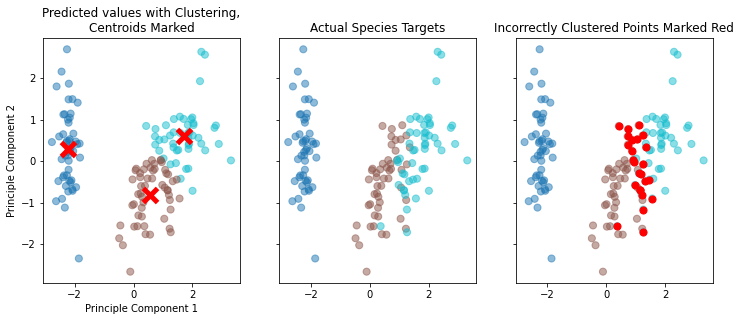

In [9]:
fig, axs = plt.subplots(1,3, figsize=(12,4.5), num = 59 ,sharex=True, sharey=True)
axs[0].scatter(X[:, 0], X[:, 1],  c=predicted_values, s=50, cmap='tab10', alpha = .5)
centers = kmeans.cluster_centers_
axs[0].scatter(centers[:, 0], centers[:, 1], marker = 'x', linewidths = 5, 
               c='red', s=200)
axs[0].set_title('''Predicted values with Clustering,
Centroids Marked''')
axs[0].set_xlabel("Principle Component 1")
axs[0].set_ylabel("Principle Component 2")


axs[1].set_title("Actual Species Targets")
axs[1].scatter(X[:, 0], X[:, 1],  c=iris_df.target.values, s=50, cmap='tab10', alpha = .5)


axs[2].set_title('''Incorrectly Clustered Points Marked Red''')
axs[2].scatter(X[:, 0], X[:, 1],  c=iris_df.target.values, s=50, cmap='tab10', alpha = .5)
axs[2].scatter(wrong_predict.values[:, 0], wrong_predict.values[:, 1], c = 'red', s = 50, alpha = 1)


#### 3D Plots of K-Means Results: Using Principle Component 1, 2, and 3
Here, we produce the same plots as above, but this time in 3 (WOW) dimensions

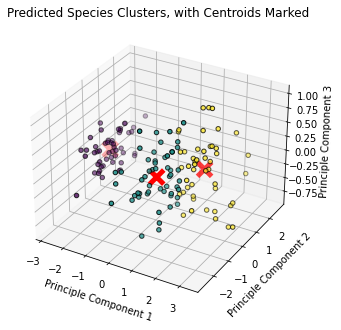

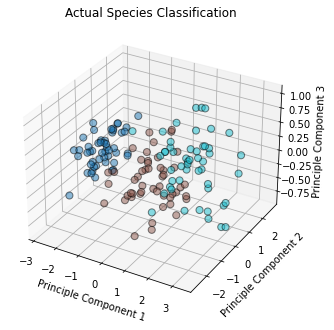

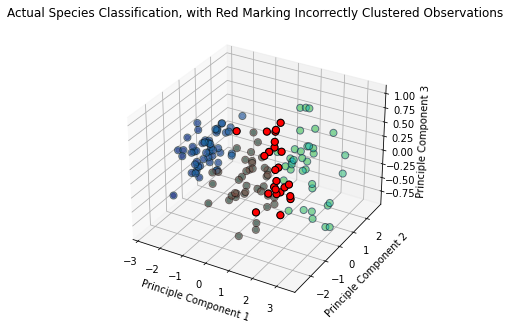

In [10]:
# Same Plots, in 3D
fig1 = plt.figure()
ax1 = Axes3D(fig1, title = "Predicted Species Clusters, with Centroids Marked")
ax1.scatter3D(X[:,0], X[:,1], X[:,2], c=predicted_values, edgecolor='k')
ax1.scatter3D(centers[:, 0], centers[:, 1], centers[:,2], marker = 'x', linewidths = 5, 
               c='red', s=200)
ax1.set_xlabel("Principle Component 1")
ax1.set_ylabel("Principle Component 2")
ax1.set_zlabel("Principle Component 3")
plt.show()

fig2 = plt.figure()
ax2 = Axes3D(fig2, title = "Actual Species Classification")
ax2.scatter3D(X[:, 0], X[:, 1], X[:,2],  c=iris_df.target.values, s=50, cmap='tab10', alpha = .5, edgecolor='k')
ax2.set_xlabel("Principle Component 1")
ax2.set_ylabel("Principle Component 2")
ax2.set_zlabel("Principle Component 3")
plt.show()

fig3 = plt.figure()
ax3 = Axes3D(fig3, title = "Actual Species Classification, with Red Marking Incorrectly Clustered Observations")
ax3.scatter3D(X[:,0], X[:,1], X[:,2], c=predicted_values)
ax3.scatter3D(X[:, 0], X[:, 1], X[:,2], c=iris_df.target.values, s=50, cmap='tab10', alpha = .5, edgecolor = 'k')
ax3.scatter3D(wrong_predict.values[:, 0], wrong_predict.values[:, 1], wrong_predict.values[:, 2], c = 'red', s = 50, alpha = 1, edgecolor='k')
ax3.set_xlabel("Principle Component 1")
ax3.set_ylabel("Principle Component 2")
ax3.set_zlabel("Principle Component 3")
plt.show()

### Visual Analysis
In the above plots, we can see K-Means clustering comes up short. For one, it failed to properly predict 25 of the observations, which are highlighted in red in the 3rd plot of the 2D and 3D plots.

While it's not readily apparent in this dataset, K-Means is also **not** suitable for datasets with uneven observations between the classes. This is because K-Means tends to create clusters of even size. Violation of this assumption can be seen in the below image of a dataset called "Mouse", which has an uneven number of observations for each class. Additionally, K-Means naturally requires *k* to be specified. In real life, we might not know how many clusters *should* exist in the data.

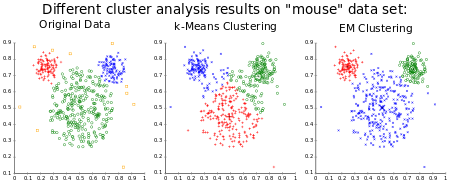

In [15]:
from IPython.display import Image
Image("/Users/villalpando/Desktop/mouse.png")

### Quantifying the performance of K-Means
While visual assessments can be useful, how can we *quantify* how well our data has been clustered? The real answer is *it depends*. sk-learn lists around 8 different metrics, but for the sake of brevity, we'll examine two: **Rand Index** and the **Silhouette Coefficient**.

#### Rand Index
Yes, *Rand* Index. Not random–the guy who made it is named Rand. This is poor naming for a metric related to statistics, but I digress. The semantics of what the Rand index *does* is important: it measures the *similarity* between two clusterings. While it is akin to "accuracy", Rand index doesn't necessarily compare a predicted clustering and the true class assignments–a necessity for accuracy. Rand index can also be used to gauge the similarity between two different clustering assignments. For example, we can evaluate the similarity between, say, a K-Means clustering assignment and a Spectral Clustering assignment. In this segment, we'll do the former: compute the similarity between the predicted values from the k-means algorithm and the true class assignments for each observation. As input for the sklearn's rand_score function, we provide two arrays of equal size: the first is a vector of the *actual* species values for each observation, and the second is a vector of the predicted values from the k-means function called above (the order in which they're assigned does not change the score):


In [20]:
metrics.rand_score(iris_df.target.values, predicted_values)

0.8322147651006712

As mentioned, this is a score of *similarity* between the two vectors. It's not quite equivalent to accuracy, but we can very easily compute that below using variables assigned above and see that the two scores are not terribly different:

In [29]:
(150 - len(wrong_predict.values)) / 150

0.8333333333333334

So, the predicted values from the clustering assignment by K-Means is roughly 83% similar to the actual classification of the species of Irises. Not terrible, but we definitely scored some free points in correctly clustering the easily differentiated observations for the first species. If we only account for the observations of the latter two species, our score is considerably lower at 75~%. I believe this is an appropriate altering of the metric given that all incorrect clusterings were not part of the first species.

#### Silhouette Coefficient
Although the Rand Index is useful in the world of uber clean data, let's take off our hazmat suits for a moment and think about how unsanitary real-world data is. In many cases, the true classification of each observation is *not* known. In such cases, the Rand Index will do us no good. We'll need a dirty tool for dirty data: the **Silhouette Coefficient**.

I'll spare some egregious re*writing* of the wheel here, as I think Wikipedia's definition of the Silhouette Coefficient explains what it is perfectly:
>The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The silhouette ranges from −1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. If most objects have a high value, then the clustering configuration is appropriate. If many points have a low or negative value, then the clustering configuration may have too many or too few clusters.

In [45]:
metrics.silhouette_score(X, predicted_values, metric='euclidean')

0.46613062910381414

Remember: The Silhouete Coefficient ranges from -1 to 1, and gauges how well an *observation* is matched to its assigned cluster and how poorly it is matched to neighboring clusters. So, this value shown above is actually the *mean* of the coefficient across all observations. One caveat to the silhouette coefficient is that it requires more than 1 cluster, so filtering the data for the first species will not allow us to calculate a silhouette coefficient (it's definitely as close 1 as you can get, however). Let's try calculating the coefficient for the latter 2 species, where according to the visualizations, is where there is a lot of need to tease apart some of the data:

In [57]:
metrics.silhouette_score(X[50:], predicted_values[50:], metric = 'euclidean')

0.3817034431400039

Not great. Let's move on and attempt a different type of clustering method. We'll revisit these two metrics once we have some new models to test.

## Data Hierarchy: Agglomerative Clustering

In [71]:
model = AgglomerativeClustering(n_clusters=3, linkage = 'ward')
model = model.fit(X)
agg_predicted = model.labels_
agg_labels = LabelTransformer().fit_transform(agg_predicted, iris_df.target.values)

Another method for clustering is known as **Agglomerative Clustering**. Agglomerative Clustering is a type of *hierarchical* clustering that begins with every observation being placed into its own clustering. At each step in the process, clusters are merged or split based on some chosen criterion. For this project, and sk-learn's default "linkage" parameter, I used "Ward's Method", which seeks to minimize the amount of variance within a cluster by  merging a pair at each step that leads to the smallest increase in variance.
#### Evaluating Performance
Although the Silhouette coefficient is useful, obviously the best choice would be a Rand index because we already know the true outcomes of each observation.

In [55]:
metrics.rand_score(iris_df.target.values, agg_labels)

0.8306040268456376

This isn't terribly worse than K-Means in this instance, but it is roughly .2% less similar to the actual class labels. We can visualize the created hierarchy using a Dendrogram.

### Dendrogram

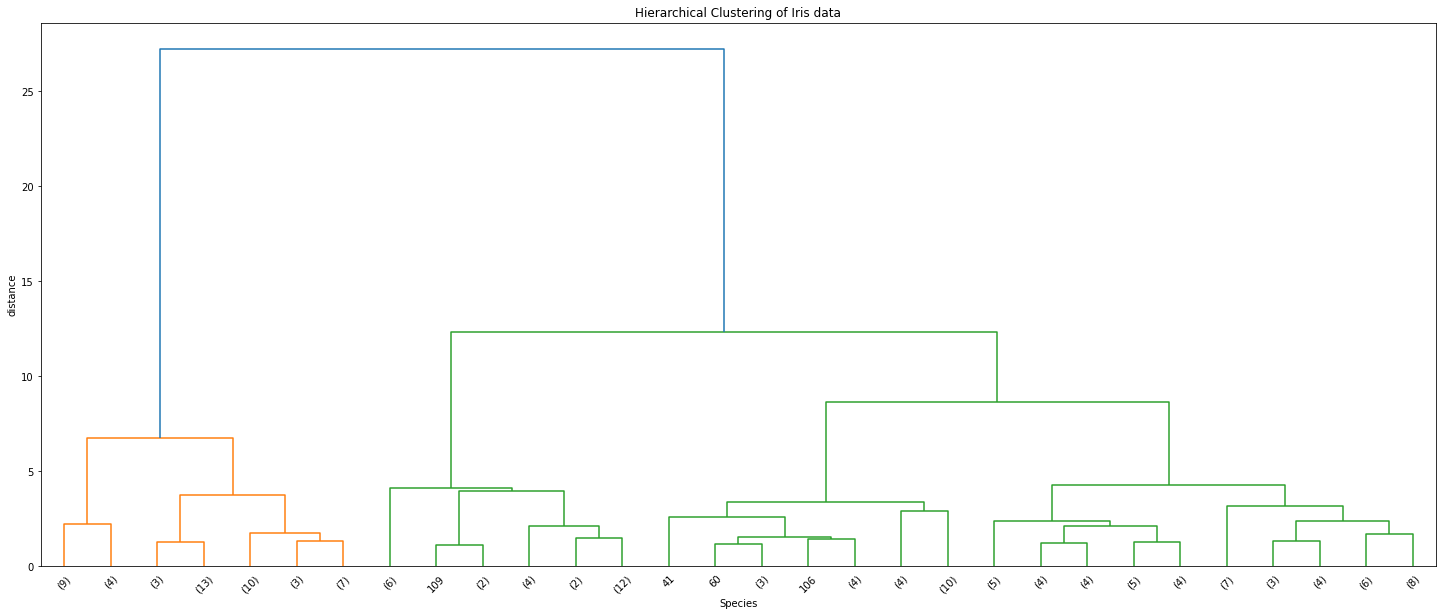

In [70]:
# A 'linkage matrix' is required as input for a dendrogram
Z = linkage(X, 'ward')

plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering of Iris data')
plt.xlabel('Species')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',            
    leaf_rotation=45,
    leaf_font_size=10
)
plt.show()

It's important to note that in general, a dendrogram isn't useful for determining a number of clusters. At first glance, how many clusters would this dendrogram suggest? We know for a fact there ought to be 3 in this dataset, but that's not immediately clear (at least to me). At the very least, like any other model, the dendrogram was at least able to easily separate setosa (shown in orange) from the rest of the dataset. Still, the divide between versicolor and virginica is muddled. While agglomerative clustering did not increase performance, it begs the question: *why* use it in the first place? A good usecase for agglomerative clustering is for a large dataset with potentially high numbers of clusters–not well-suited for the Iris dataset, seemingly.

## A Final Method: Gaussian Mixture
I'm hoping this assignment ends with a mic drop as opposed to being booed off the Data Mining stage, so here I put all my chips on Gauss. Gaussian Mixture as a method for clustering is a complicated one, and truth be told, a lot of its parameters fly over my head at the moment. However, given the seemingly powerful ability to cluster noisy data, it's definitely a method I'll need to explore in further detail. From what I've gathered, essentially what the Gaussian Mixture method does is computes a probability that an observation belongs to a particular cluster, given the mean and covsriance matrix for that cluster, and chooses the maximum of the probabilities among candidate clusters.
#### Fitting the Model, Performance:

In [80]:
gauss = GaussianMixture(n_components=3,
              covariance_type='tied', max_iter=20, random_state=0).fit_predict(X)
metrics.rand_score(iris_df.target.values, gauss)

0.9495302013422818

Markedly better than the other methods employed, according to the Rand index.
#### Visualization Revisited
Now that we have found a method that markedly improves clustering compared to K-Means, let's revisit some of the previous visualizations to see the difference in performance visually.

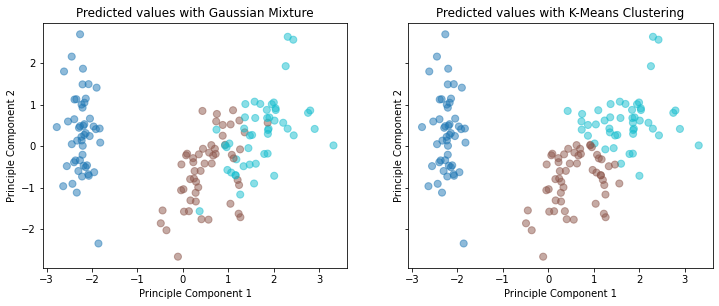

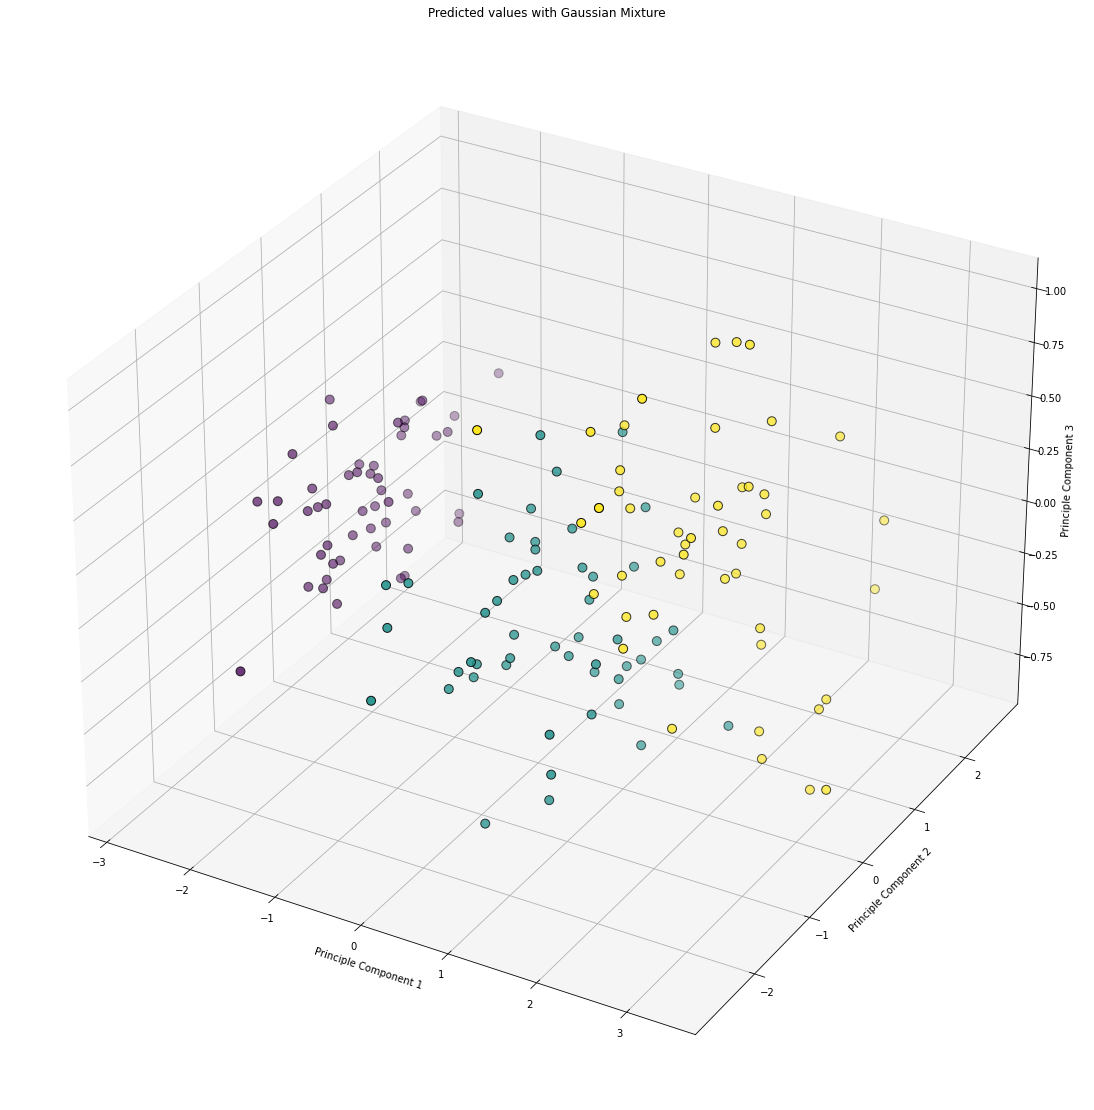

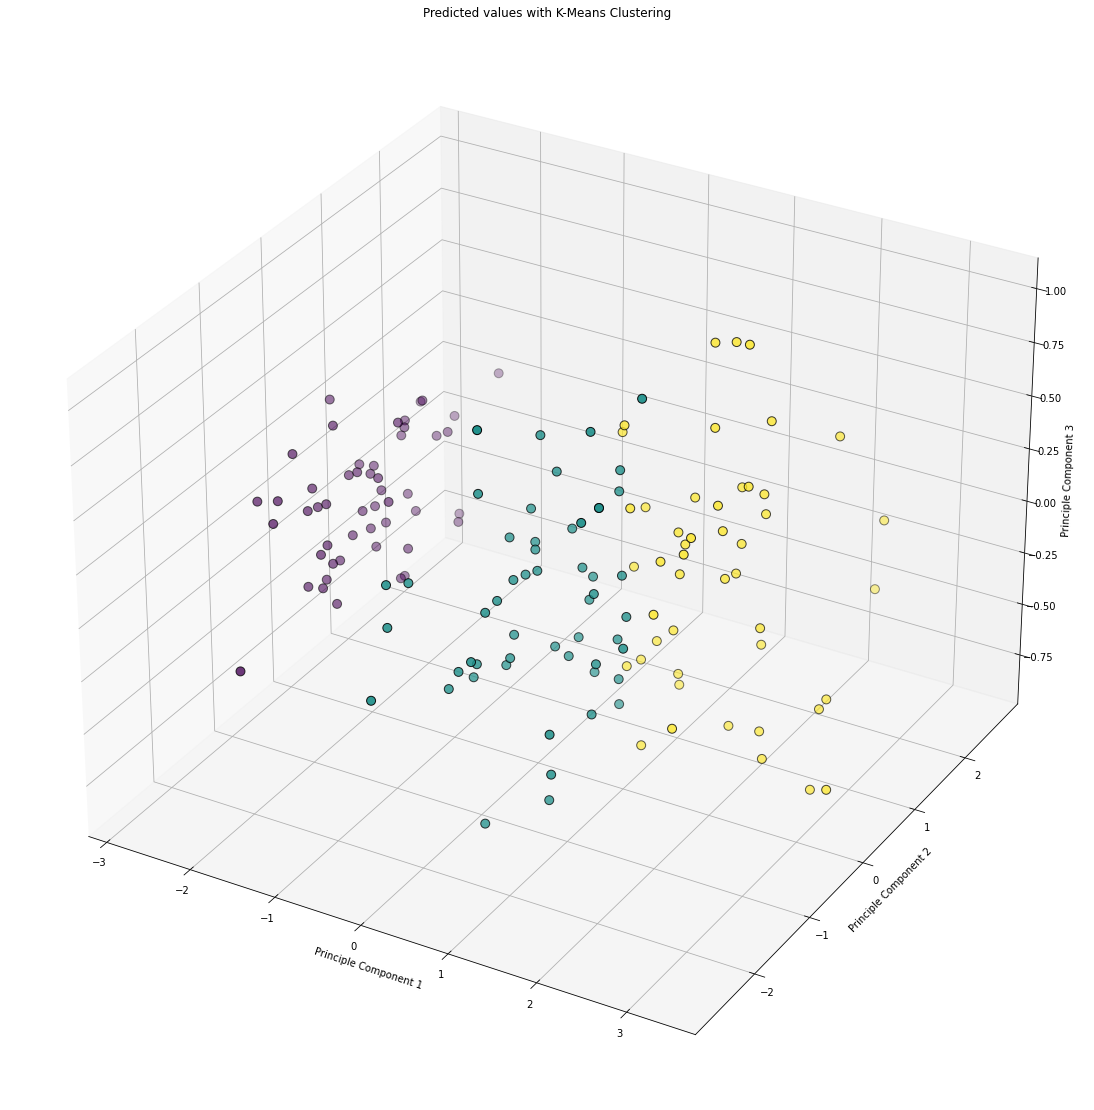

In [103]:
fig_, axs_ = plt.subplots(1,2, figsize=(12,4.5), num = 59 ,sharex=True, sharey=True)
axs_[0].scatter(X[:, 0], X[:, 1],  c=gauss, s=50, cmap='tab10', alpha = .5)
axs_[0].set_title('''Predicted values with Gaussian Mixture''')
axs_[0].set_xlabel("Principle Component 1")
axs_[0].set_ylabel("Principle Component 2")


axs_[1].scatter(X[:, 0], X[:, 1],  c=predicted_values, s=50, cmap='tab10', alpha = .5)
axs_[1].set_title('''Predicted values with K-Means Clustering''')
axs_[1].set_xlabel("Principle Component 1")
axs_[1].set_ylabel("Principle Component 2")

fig4 = plt.figure()
ax1 = Axes3D(fig4, title = "Predicted values with Gaussian Mixture")
ax1.scatter3D(X[:,0], X[:,1], X[:,2], c=gauss, edgecolor='k', s= 80)
ax1.set_xlabel("Principle Component 1")
ax1.set_ylabel("Principle Component 2")
ax1.set_zlabel("Principle Component 3")

fig5 = plt.figure()
ax2 = Axes3D(fig5, title = "Predicted values with K-Means Clustering")
ax2.scatter3D(X[:,0], X[:,1], X[:,2], c=predicted_values, edgecolor='k', s = 80)
ax2.set_xlabel("Principle Component 1")
ax2.set_ylabel("Principle Component 2")
ax2.set_zlabel("Principle Component 3")
plt.show()

The difference is much more obvious in the 2D graphs in my opinion: the division created between the clusters is not as simply as drawing a straight line through the data in Gaussian Mixture. It managed to tease apart some of the noisy data–something not so feasible with K-Means, seemingly.
# Conclusion
PCA was primarily used here as an exploration of dimensionality reduction, and, surely, the performance of each clustering method would increase somewhat if used on the full dataset. Still, using it as input for each of the methods explored in this assignment provided enough to explore the differences between the three.

From the results, it seems like K-Means and Agglomerative Clustering fell short of the true problem in the Iris dataset: the division between versicolor and virginica is not an easy one to tease apart. Gaussian Mixture faired much better, boasting a Rand index score of close to 95%. A key component to this is that Gaussian Mixture accounts for variance within each cluster–something not utilized by K-means.

It's also important to note that in a real-life dataset with uneven observations for each class, K-Means would be far from my first choice. While not apparent in the balanced Iris dataset, K-means will tend to create even-sized clusters. In real life, we'd be hard pressed to find an even division of classes.

Overall, we shouldn't necessarily see the relatively poor performance of K-Means and Agglomerative clustering as a bad thing. Keep in mind that clustering is unsupervised, and well-suited for cases where one might not know anything about how data is clustered, if at all–let alone knowing a true class label for each observation. Taking away the column vector for actual species, I'd take a machine-given 83% accuracy over my own guesstimations any day.